# Scientific Authors Collaboration
Link: https://snap.stanford.edu/data/ca-HepTh.html
> This datasets contains a collaboration network that covers scientific collaborations between authors papers submitted to High Energy Physics - Theory category. If an author co-authored a paper with another author, the graph contains a undirected edge between them.

In [108]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
import sys
sys.path.append('../')
from utils import negative_sampling as ns, splits

# Const
dataset = "data/CA-HepTh.txt"
random.seed(42)

In [109]:
## Create Graph ##
G = nx.read_edgelist(dataset, nodetype=int)

print("Nodes:",len(list(G.nodes)))
print("Edges:",len(list(G.edges)))

Nodes: 9877
Edges: 25998


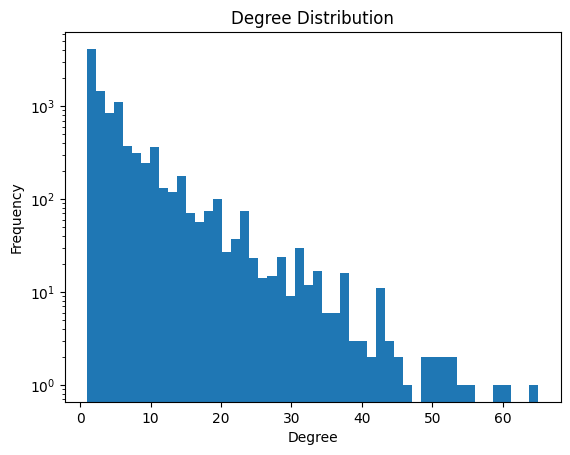

In [110]:
# Degree Distribution Plot
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale("log")
plt.show()

In [111]:
# Number of connected components
print("Number of connected components:", nx.number_connected_components(G))
largest_cc = max(nx.connected_components(G), key=len)
print("Size of largest component:", len(largest_cc))

Number of connected components: 429
Size of largest component: 8638


In [112]:
def build_feature_dataset(pairs, G, features=None):
    # Default to all features if none specified
    if features is None:
        features = ['cn', 'jc', 'aa', 'pa', 'ra']

    feature_data = {}

    if 'cn' in features:
        feature_data['cn'] = [len(list(nx.common_neighbors(G, u, v))) for u, v in pairs]

    if 'jc' in features:
        feature_data['jc'] = [coeff for _, _, coeff in nx.jaccard_coefficient(G, pairs)]

    if 'aa' in features:
        aa_scores = []
        for u_node, v_node in pairs:
            try:
                _, _, score = list(nx.adamic_adar_index(G, [(u_node, v_node)]))[0]
                aa_scores.append(score)
            except ZeroDivisionError:
                aa_scores.append(0.0)
            except StopIteration:
                aa_scores.append(0.0)
        feature_data['aa'] = aa_scores

    if 'pa' in features:
        feature_data['pa'] = [coeff for _, _, coeff in nx.preferential_attachment(G, pairs)]

    if 'ra' in features:
        feature_data['ra'] = [coeff for _, _, coeff in nx.resource_allocation_index(G, pairs)]

    # Combine feature
    feature_vectors = []
    for i in range(len(pairs)):
        vector = [feature_data[feat][i] for feat in features]
        feature_vectors.append(vector)

    return feature_vectors

In [ ]:
feature_combinations = [
    # Single features
    (['cn'], '(cn)'),
    (['jc'], '(jc)'),
    (['aa'], '(aa)'),
    (['pa'], '(pa)'),
    (['ra'], '(ra)'),

    # Progressive combinations
    (['cn', 'jc'], '(cn, jc)'),
    (['cn', 'jc', 'aa'], '(cn, jc, aa)'),
    (['cn', 'jc', 'aa', 'pa'], '(cn, jc, aa, pa)'),
    (['cn', 'jc', 'aa', 'pa', 'ra'], '(cn, jc, aa, pa, ra)'),

    # Additional interesting combinations
    (['cn', 'aa'], '(cn, aa)'),
    (['cn', 'pa'], '(cn, pa)'),
    (['cn', 'ra'], '(cn, ra)'),
    (['jc', 'aa'], '(jc, aa)'),
    (['jc', 'pa'], '(jc, pa)'),
    (['jc', 'ra'], '(jc, ra)'),
    (['aa', 'pa'], '(aa, pa)'),
    (['aa', 'ra'], '(aa, ra)'),
    (['pa', 'ra'], '(pa, ra)'),

    # Three feature combinations
    (['cn', 'jc', 'ra'], '(cn, jc, ra)'),
    (['cn', 'aa', 'ra'], '(cn, aa, ra)'),
    (['jc', 'aa', 'ra'], '(jc, aa, ra)'),
]

results_list = []

for features, description in feature_combinations:
    # Create train/test split with current feature combination
    X_train, X_test, y_train, y_test = splits.create_train_test_split(
        G,
        lambda pairs, G: build_feature_dataset(pairs, G, features=features),
        lambda: ns.random_negative_sampling(G)
    )

    # Train and evaluate
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    auc_pr = average_precision_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)

    results_list.append({
        'Features': description,
        'AUC_ROC': auc_roc,
        'AUC_PR': auc_pr,
        'Has_PA': 'pa' in features,
    })

df = pd.DataFrame(results_list)
df[["Features", "AUC_ROC", "AUC_PR"]]

,Features,AUC_ROC,AUC_PR
0,(cn),0.862848,0.862313
1,(jc),0.866204,0.865800
2,(aa),0.863926,0.863681
3,(pa),0.719961,0.757167
4,(ra),0.863796,0.863874
5,"(cn, jc)",0.866283,0.866021
6,"(cn, jc, aa)",0.867253,0.866162
7,"(cn, jc, aa, pa)",0.860353,0.911395
8,"(cn, jc, aa, pa, ra)",0.852792,0.909129
9,"(cn, aa)",0.863638,0.863175


### Results analysis
Features that directly measure the shared neighborhood or short paths between nodes, such as Jaccard Coefficient (jc), Common Neighbors (cn), Resource Allocation (ra), and Adamic-Adar (aa), achieved the highest AUC-ROC scores when used individually or in combination.

The top-performing combination for AUC-ROC was (jc, aa). A normalized count of common neighbors (jc) combined with a measure that penalizes high-degree common neighbors (aa) provides a strong combination for link prediction.

Combining 2 or 3 complementary features (e.g., (jc, aa), (cn, ra), (cn, jc, aa)) generally perform with the best AUC-ROC scores.

Preferential Attachment (pa) alone had the lowest AUC-ROC score among all individual features. This suggests that the "rich get richer" rule doesn't apply well in this domain. However when combined to other feature it gives contrasting results for the two performance scores:
- With AUC-ROC: adding PA to combinations of other features the AUC-ROC score often does not improve significantly and sometimes even sees a slight decrease. That happens because ROC assign scores based on the ability of the model to separate all positives from all negatives, and PA makes some positives and some negatives to boost their scores (and probably the negatives boosted are more than the positives).
- With AUC-PR: adding PA to strong feature combinations consistently resulted in a significant boost to the AUC-PR score. That happens because PR assigns higher scores to the new true positives that PA finds. 

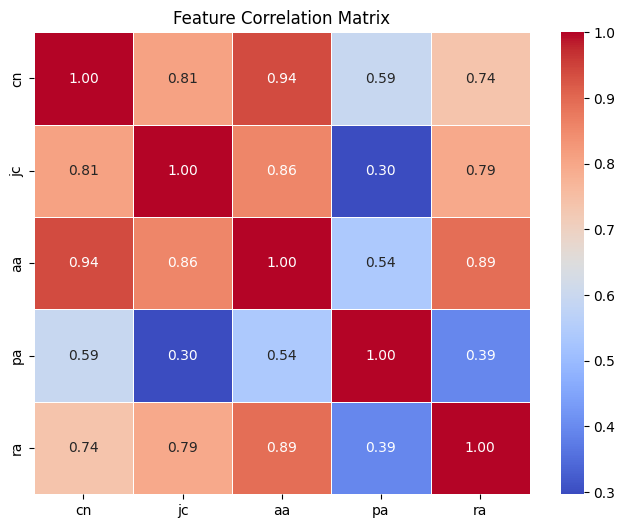

In [114]:
features=['cn', 'jc', 'aa', 'pa', 'ra']
X_train_for_corr, _, _, _ = splits.create_train_test_split(
    G,
    lambda p, G: build_feature_dataset(p, G, features),
    lambda: ns.random_negative_sampling(G)
)

# Calculate the correlation matrix
correlation_matrix = pd.DataFrame(X_train_for_corr, columns=features).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Feature Correlation Matrix')
plt.show()

Preferential Attachment is anyway the only topology feature that is not correlated with others, making an important factor to consider.